In [2]:

import configparser
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from binance.client import Client

In [3]:
CFG_FL_NAME = "../user.cfg"
USER_CFG_SECTION = "binance_user_config"
config = configparser.ConfigParser()
config.read(CFG_FL_NAME)

api_key = config.get(USER_CFG_SECTION, "api_key")
api_secret = config.get(USER_CFG_SECTION, "api_secret_key")
client = Client(api_key, api_secret)

In [4]:
def get_ticker_price(ticker_symbol: str, days:int ):
    """
    Get ticker price of a specific coin
    """

    target_date = (datetime.now() -timedelta(days = days)).strftime("%d %b %Y %H:%M:%S")
    key = f"{ticker_symbol}"
    end_date = datetime.now() 
    end_date = end_date.strftime("%d %b %Y %H:%M:%S")
    
    coindata = pd.DataFrame(columns = [key])
    
    prices = []
    dates = []
    for result in client.get_historical_klines(
        ticker_symbol, "1m", target_date, end_date, limit=1000
        ):
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime("%d %b %Y %H:%M:%S")
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    coindata[key] = prices
    coindata['date'] = dates

    return(coindata.reindex(columns =['date',key]))

In [5]:
# Grab coin prices from binance server 
# Add your own obviously


coinIDs = ['BTC',
           'ETH',
           'ADA',
           'SOL',
           'XRP',
           'DOT',
           'LINK',
           'UNI',
           'LTC',
           'ALGO', ]

cointickers = [coin + 'USDT' for coin in coinIDs]

### Set Period here, this is the number of days of data you want to download for each coin ###
num_days = 1
###

#Create initial df with first coin then fill with all from list

coindata = get_ticker_price(cointickers[0], num_days)

for tick in cointickers[1:]:
    newdata = get_ticker_price(tick, num_days)
    coindata = pd.merge(coindata, newdata)



c:\users\skhan\python-practice\binance-trade-bot\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
c:\users\skhan\python-practice\binance-trade-bot\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
c:\users\skhan\python-practice\binance-trade-bot\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 

<AxesSubplot:xlabel='date'>

<Figure size 1440x576 with 0 Axes>

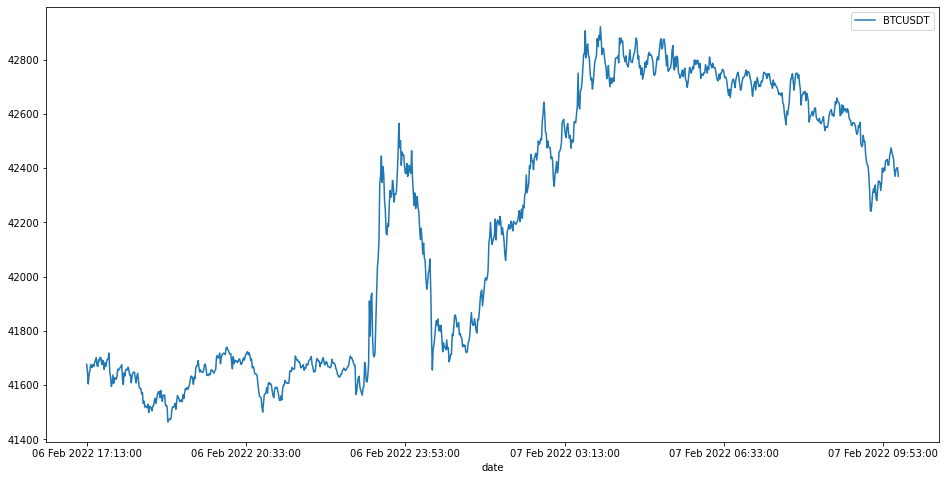

In [6]:
## Sanity checker, Are we getting the data? Let's plot it

def plotmovement(x1, y1,ticker):
    '''
    plots the noise of two coins 
    '''
    fig = plt.figure(figsize=(20,8))
    plt.plot( x1, y1,label=ticker)
    plt.legend()

## Too much data so lets just plot a subset.
    
start = 0
end = 200

fig = plt.figure(figsize=(20,8))
coindata.plot('date','BTCUSDT',figsize = (16,8),)

In [7]:
# print correlation table

coindata.corr()

,BTCUSDT,ETHUSDT,ADAUSDT,SOLUSDT,XRPUSDT,DOTUSDT,LINKUSDT,UNIUSDT,LTCUSDT,ALGOUSDT
BTCUSDT,1.000000,0.971267,0.898752,0.949887,0.877936,0.978328,0.962355,0.957228,0.922334,0.937576
ETHUSDT,0.971267,1.000000,0.869500,0.953593,0.907434,0.978614,0.982809,0.978937,0.914992,0.965949
ADAUSDT,0.898752,0.869500,1.000000,0.817615,0.931493,0.905337,0.888450,0.887062,0.914050,0.874615
SOLUSDT,0.949887,0.953593,0.817615,1.000000,0.846705,0.943180,0.949596,0.929360,0.825179,0.937314
XRPUSDT,0.877936,0.907434,0.931493,0.846705,1.000000,0.914663,0.936533,0.913056,0.877527,0.934829
DOTUSDT,0.978328,0.978614,0.905337,0.943180,0.914663,1.000000,0.978417,0.980587,0.938484,0.947239
LINKUSDT,0.962355,0.982809,0.888450,0.949596,0.936533,0.978417,1.000000,0.982375,0.917355,0.976588
UNIUSDT,0.957228,0.978937,0.887062,0.929360,0.913056,0.980587,0.982375,1.000000,0.941354,0.958208
LTCUSDT,0.922334,0.914992,0.914050,0.825179,0.877527,0.938484,0.917355,0.941354,1.000000,0.906813
ALGOUSDT,0.937576,0.965949,0.874615,0.937314,0.934829,0.947239,0.976588,0.958208,0.906813,1.000000


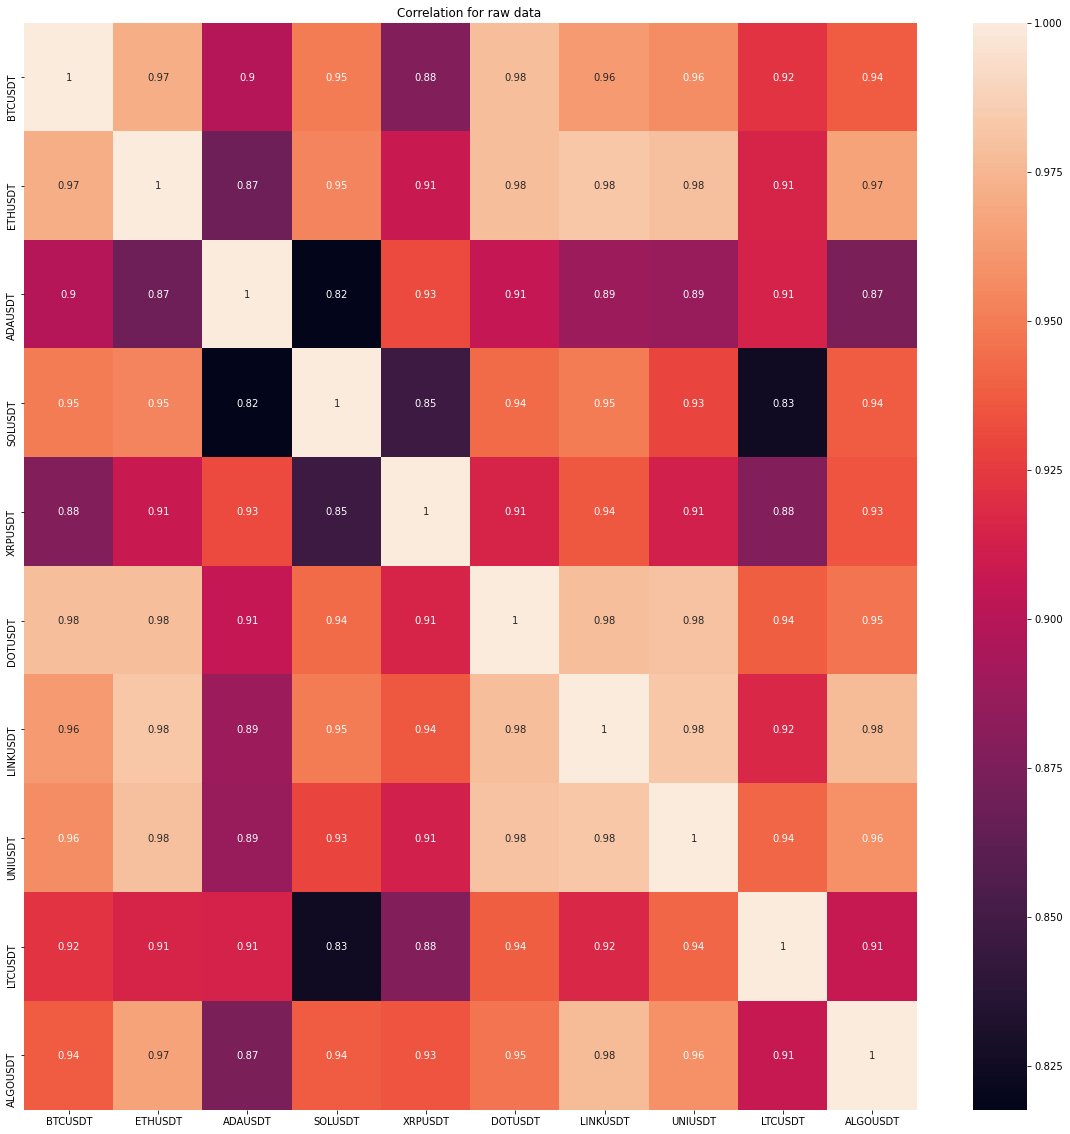

In [8]:
## Correlation matrix for raw data. 

corrMatrix = coindata.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for raw data ')
plt.show()

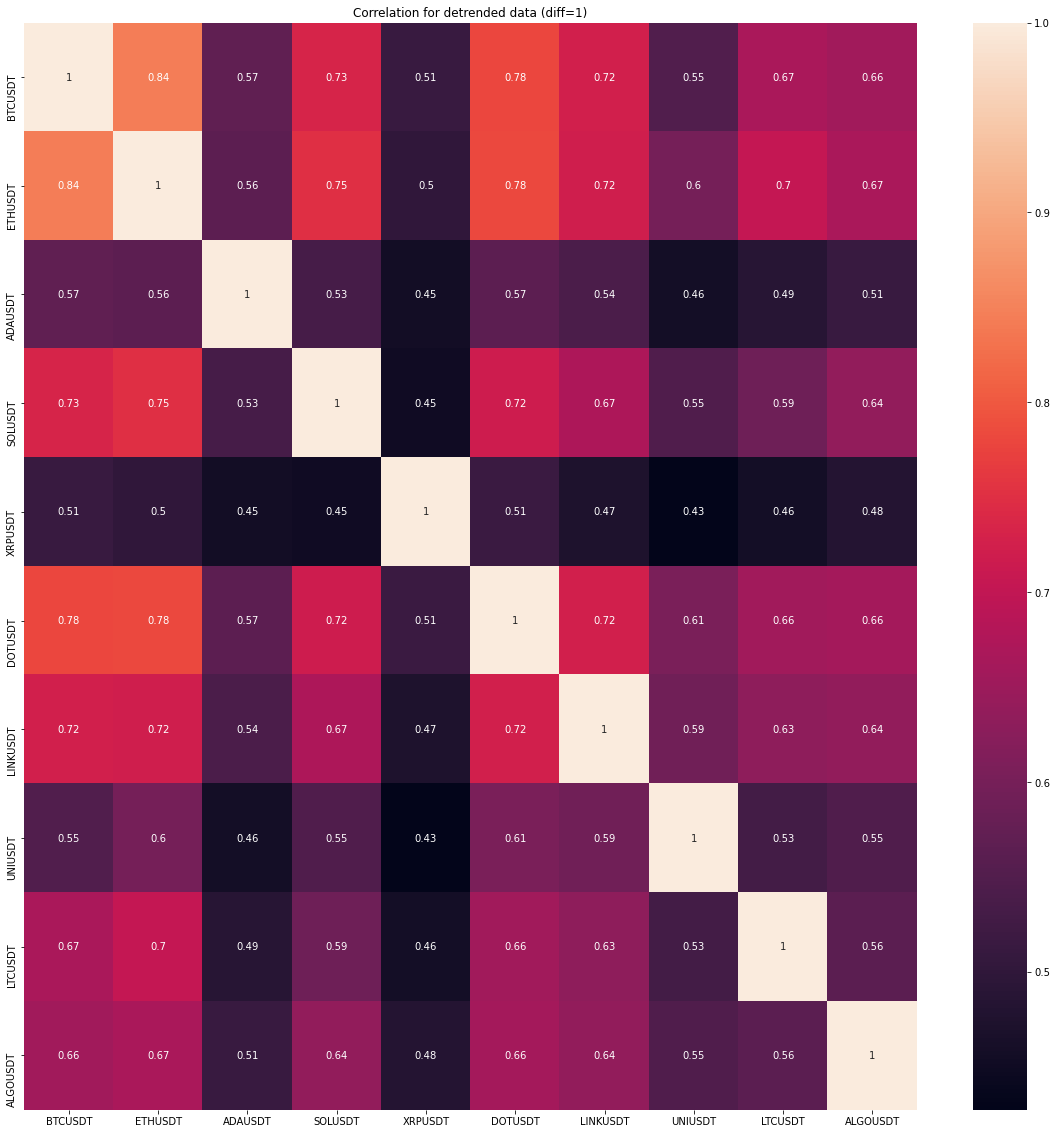

In [9]:
### Detrend the data using first difference 
### more info at https://youtu.be/nPYPyh20gGo

detrendeddata = pd.DataFrame()

for column in coindata:
    if column != 'date':
        detrendeddata[column] = coindata[column].diff(1)
        
corrMatrix = detrendeddata.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for detrended data (diff=1)')
plt.show()

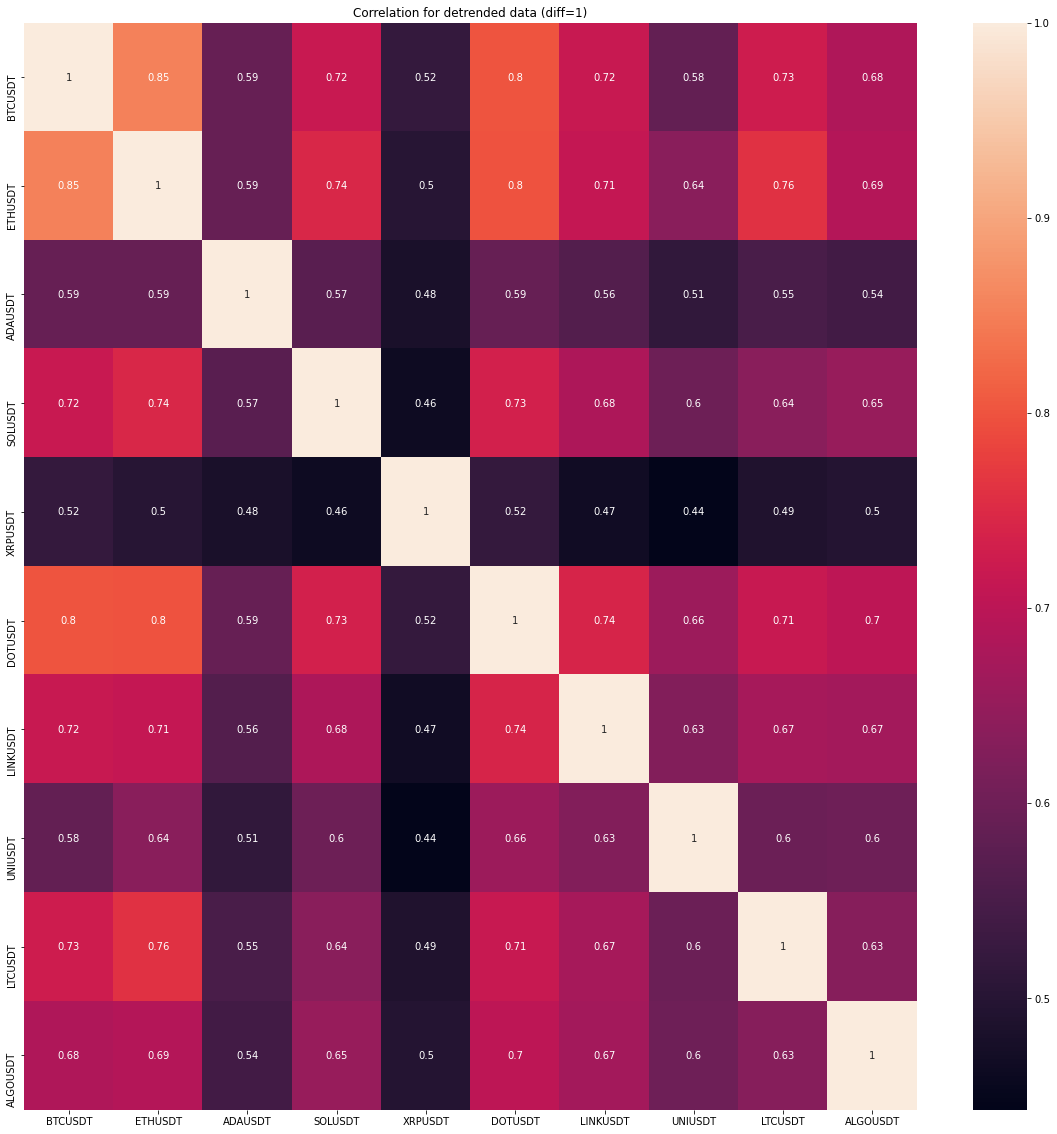

In [10]:
### Detrend the data using rolling average
radf = pd.DataFrame()

for column in coindata:
    if column != 'date':
        radf[column] = coindata[column]-coindata[column].rolling(window=3).mean()
        
corrMatrix = radf.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for detrended data (diff=1)')
plt.show()

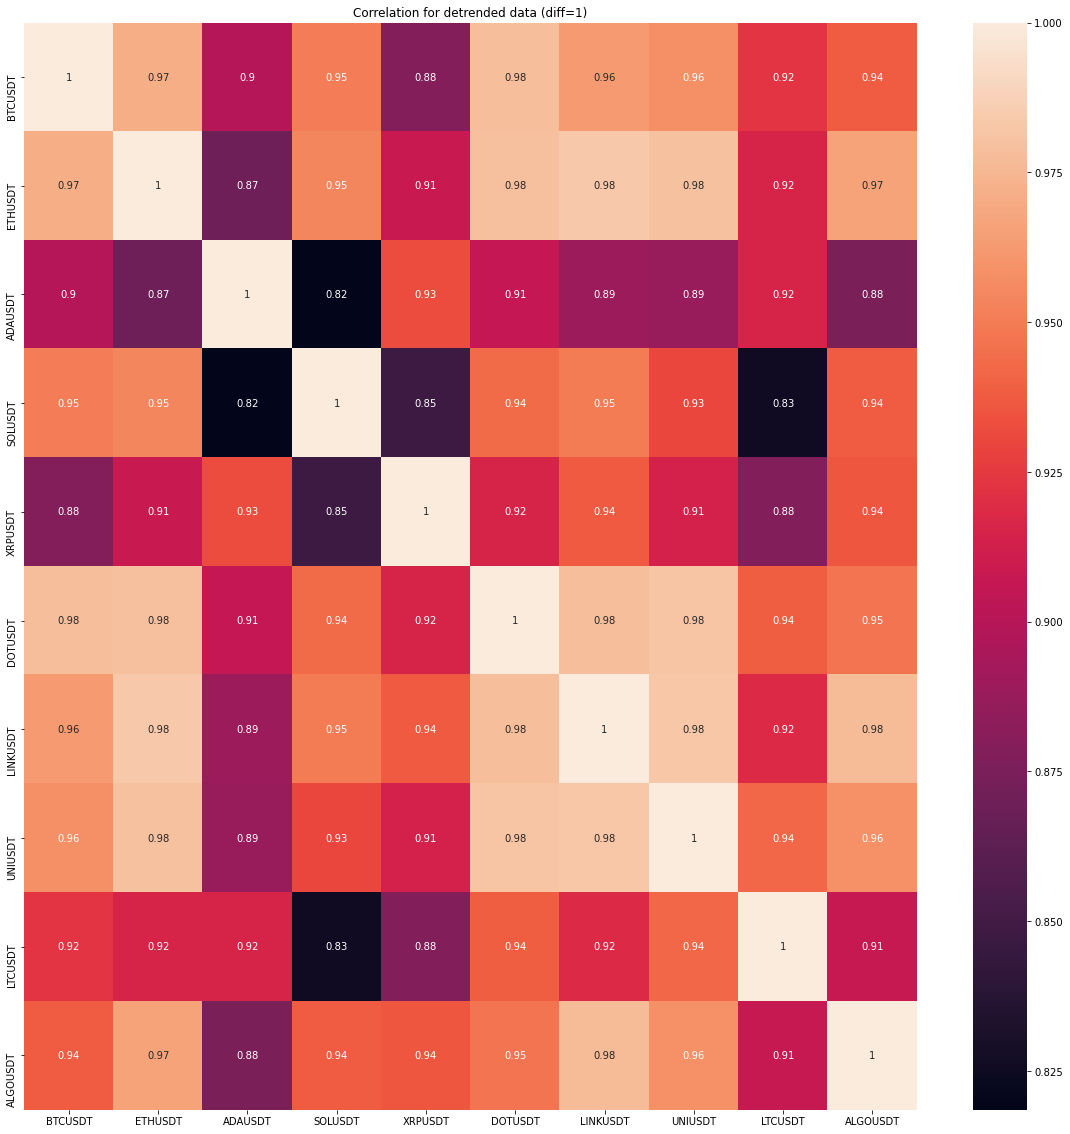

In [11]:
### Examine the trend of the rolling average

radf2 = pd.DataFrame()

for column in coindata:
    if column != 'date':
        radf2[column] = coindata[column].rolling(window=3).mean()

corrMatrix = radf2.corr()
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation for detrended data (diff=1)')
plt.show()